In [1]:
import numpy as onp
import jax.numpy as np
from jax import random
from jax import jit
from jax_md.util import *
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax_md import quantity
import jax_md
print(dir(jax_md))
from jax_md import energy, partition
from jax_pd import space, materials, damage, mesh, plots, solvers, util


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'energy', 'interpolate', 'minimize', 'partition', 'quantity', 'simulate', 'smap', 'space', 'util']


/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [23]:
displacement_fn, shift_fn = space.free()

R = onp.array([[i,j,k] for i in range(20) for j in range(20) for k in range(20)],dtype=np.float32)

mask = (R[:,0]<4)|((R[:,0]>15)&(R[:,1]>8)&(R[:,2]>8)&(R[:,1]<11)&(R[:,2]<11))

R = np.array(R[mask])

box_size = [20,20,20]
cutoff = f32(3.0)

bonds, lengths = util.bonds_n_lengths(displacement_fn, box_size, cutoff, R)


In [24]:
bonds.shape

(55439, 2)

In [25]:

energy_fn = [materials.simple_spring_bond(displacement_fn, bond=bonds, length=lengths, epsilon=100, stretch=0.5), 
             energy.soft_sphere_pair(displacement_fn, sigma=f32(1.0), epsilon=f32(1000.0)),
            materials.anti_contact_simple_spring_bond(displacement_fn, bond=bonds, radius=f32(1.0), epsilon=100,)]

def cal_energy(R,energy_fn):
    return np.sum([i(R) for i in energy_fn])

cal_energy(R,energy_fn)

for i in energy_fn:
    print(i(R))

0.0
0.0
0.0


In [26]:
def move(R,bool,t=0,R0=R,v=np.array([[0.01,0,0]])):
    return R0[bool,:]+t*v

def fix(R,bool,t=0,R0=R):
    return R0[bool,:]


Rbc = []

iVbc = [{'bool':R[:,0]>11,'fn':fix,'kwargs':{'R0':R*0-np.array([[100,0,0]])}},
#        {'bool':R[:,0]<8,'fn':fix,'kwargs':{'R0':R*0+np.array([[0,0,0]])}},
       ]


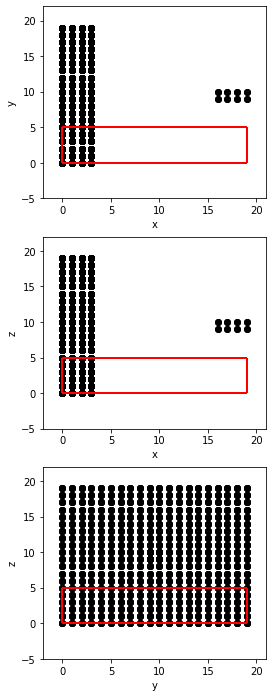

In [27]:
R1 = [R]

def myplot(i):
    x,y = 1,3
    fig, axs = plt.subplots(y,x,figsize=[4*x,4*y])
    ls = []
    ms = 5
    labels = [['x','y'],['x','z'],['y','z']]
    for ax,label in zip(axs,labels):
        ls.append(ax.plot([],[],'o', markersize=ms)[0])
        ax.set_xlim([-2, 21])
        ax.set_ylim([-5, 22])
        ax.hlines(0,0,19,zorder=10,color='r',lw=2)
        ax.hlines(5,0,19,zorder=10,color='r',lw=2)
        ax.vlines(0,0,5,zorder=10,color='r',lw=2)
        ax.vlines(19,0,5,zorder=10,color='r',lw=2)
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.axis('on')

    plots.W3(i,R1,axs,color='k')
    plt.show()

myplot(0)


In [28]:
R1 = [R]
runs = 1000
R2, state_values, states = solvers.run_simulation(key,runs,1.0e-3, R,energy_fn,shift_fn,iVbc=iVbc,mass=1.0,print_every=500,value_every=3,pos_every=1)

R1 += R2

Initial conditions(after iBC): 
KE: 80000.000000, PE: 0.000, TE: 80000.000
Initial conditions(after BC): 
KE: 80000.000000, PE: 0.000, TE: 80000.000
KE: 80000.000000, PE: 0.000, TE: 80000.000
KE: 79299.890625, PE: 657.562, TE: 79957.453
KE: 79412.632812, PE: 544.467, TE: 79957.102


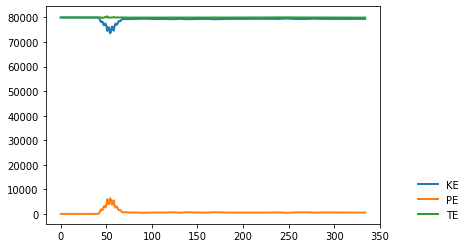

In [29]:
plt.plot(range(len(state_values)),np.array(state_values),lw=2)
plt.legend(['KE','PE','TE'],frameon=False,loc=[1.1,0])

In [14]:
F1 = []
F2 = []
mask1 = R[:,0]>10
mask2 = R[:,0]<10

F1 += [(state.acceleration[mask1,0]*state.mass).sum() for state in states]
F2 += [(state.acceleration[mask2,0]*state.mass).sum() for state in states]
    

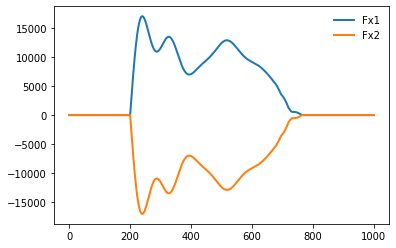

In [15]:
plt.plot(range(len(F1)),F1,label='Fx1',lw=2)
plt.plot(range(len(F2)),F2,label='Fx2',lw=2)
plt.legend(frameon=0)


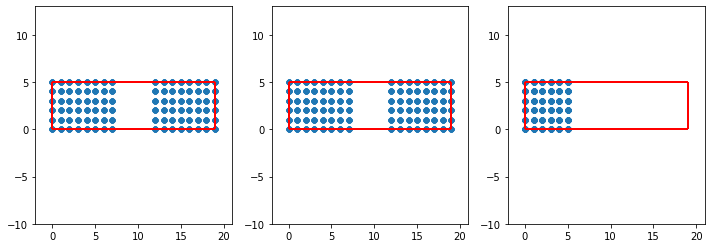

In [9]:
import matplotlib
k = 20
ms = 5

def myplot(i):
    global ax,l,k
    i = i*k
    R_plt = onp.array(R1[i])
    ls[0].set_data(R_plt[:, 0], R_plt[:, 1],) 
    ls[1].set_data(R_plt[:, 0], R_plt[:, 2],) 
    ls[2].set_data(R_plt[:, 1], R_plt[:, 2],) 


fig, axs = plt.subplots(1,3,figsize=[12,4])
ls = []
for ax in axs:
    ls.append(ax.plot([],[],'o', markersize=ms)[0])
    ax.set_xlim([-2, 21])
    ax.set_ylim([-10, 13])
    ax.hlines(0,0,19,zorder=10,color='r',lw=2)
    ax.hlines(5,0,19,zorder=10,color='r',lw=2)
    ax.vlines(0,0,5,zorder=10,color='r',lw=2)
    ax.vlines(19,0,5,zorder=10,color='r',lw=2)
    ax.axis('on')


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, myplot, frames=int(len(R1)/k))

from IPython.display import HTML
HTML(ani.to_jshtml())